In [1]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [2]:
# GLOBAL SETTINGS

# Directories
model_dataDir = 'DATA/MODELDATA/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time
START = 2020
END = 2022



#Helpers
idx = pd.IndexSlice



In [3]:
# Helper Functions
def get_trade_prices(start, stop):
    model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
    model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
    model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
    model_mdf.set_index(['Dates', 'Coin'], inplace=True)
    model_mdf = model_mdf.loc[:,'Open']
    #model_mdf = model_mdf.loc[idx[tickers, str(START):str(END)], 'Open']
    prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')
    
    return prices



def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()


def get_factor(predictions):
    return (predictions.unstack('Coin')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='Dates')
            .sort_index())    

In [4]:
# Load the Model Results Data
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')
lasso_scores = pd.read_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')
lasso_predictions = pd.read_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')

# Load the OHLV Price data
#model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
#model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
#model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
#model_mdf.set_index(['Dates', 'Coin'], inplace=True)
#model_mdf = model_mdf.loc[:,'Open':'Volume']
#prices = model_mdf.unstack('Coin').sort_index().shift(-1).tz_localize('UTC')

In [5]:
# Now we will check the Alpha and Beta metrics of the signals found by our models in the prior step

In [6]:
# From Linear Regression
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

Dates                      Coin                 
2020-01-11 00:00:00+00:00  basic-attention-token    0.003536
                           binancecoin              0.000891
                           bitcoin                  0.016788
                           bitcoin-cash             0.018614
                           bitcoin-cash-sv          0.048267
dtype: float64

In [7]:
#tickers = lr_factor.index.get_level_values('Coin').unique()

In [8]:
trade_prices = get_trade_prices(2020, 2022)
#trade_prices.info()

In [9]:
#print(len(trade_prices.columns))

In [10]:
trade_prices.head()

Coin,basic-attention-token,binancecoin,bitcoin,bitcoin-cash,bitcoin-cash-sv,bittorrent-old,cardano,celsius-degree-token,chainlink,cosmos,...,nexo,okb,quant-network,ripple,stellar,tezos,theta-token,tron,vechain,zcash
Dates,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,0.130400,5.944427,3788.302374,162.297745,90.662925,NaN,0.041668,0.039889,0.305315,NaN,...,0.077577,0.670898,1.969690,0.358617,0.113689,0.469394,0.048836,0.019152,0.004038,57.900904
2019-01-02 00:00:00+00:00,0.131381,5.991602,3843.491901,168.296744,90.935933,NaN,0.043810,0.037203,0.351586,NaN,...,0.077135,0.688876,1.981844,0.365204,0.115295,0.473115,0.050424,0.019583,0.004136,59.503055
2019-01-03 00:00:00+00:00,0.131057,5.903465,3782.520706,160.185924,88.127028,NaN,0.043039,0.043649,0.408147,NaN,...,0.077754,0.674506,2.095722,0.356237,0.112604,0.464337,0.050096,0.019842,0.004029,57.798409
2019-01-04 00:00:00+00:00,0.136790,6.043790,3836.882351,160.241877,86.649048,NaN,0.043595,0.046723,0.399615,NaN,...,0.076206,0.662406,2.511983,0.358131,0.114215,0.467652,0.050470,0.021937,0.004073,58.593813
2019-01-05 00:00:00+00:00,0.133185,5.959080,3783.684072,156.118205,86.375117,NaN,0.045979,0.036993,0.373135,NaN,...,0.073151,0.652677,2.084414,0.351579,0.111908,0.469616,0.049155,0.021881,0.004005,56.768338


In [11]:
# Get forward returns and Quantiles
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      #periods=(1, 7, 14, 30, 60, 90))
                                                      periods=(1, 7, 14, 30))

lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28391 entries, (Timestamp('2020-01-11 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28391 non-null  float64
 1   7D               28391 non-null  float64
 2   14D              28391 non-null  float64
 3   30D              28391 non-null  float64
 4   factor           28391 non-null  float64
 5   factor_quantile  28391 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.334586,0.076535,-0.016545,0.025089,5824,20.513543
2,-0.237435,0.089257,-0.003168,0.020211,5823,20.510021
3,-0.216736,0.094624,0.002774,0.019455,5097,17.952872
4,-0.197750,0.113821,0.008638,0.019461,5823,20.510021
5,-0.175048,0.227444,0.021125,0.022943,5824,20.513543


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,0.793,0.528,0.420,0.441
beta,0.026,0.084,0.128,0.075
Mean Period Wise Return Top Quantile (bps),26.704,23.108,23.985,26.045
Mean Period Wise Return Bottom Quantile (bps),-8.348,-16.263,-18.161,-15.748
Mean Period Wise Spread (bps),35.052,38.488,41.760,40.253


Information Analysis


,1D,7D,14D,30D
IC Mean,0.024,0.047,0.073,0.094
IC Std.,0.204,0.205,0.207,0.221
Risk-Adjusted IC,0.117,0.230,0.351,0.427
t-stat(IC),3.144,6.206,9.481,11.534
p-value(IC),0.002,0.000,0.000,0.000
IC Skew,0.076,-0.083,0.119,-0.058
IC Kurtosis,-0.183,-0.159,-0.012,-0.287


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.370,0.635,0.723,0.772
Quantile 2 Mean Turnover,0.588,0.739,0.764,0.781
Quantile 3 Mean Turnover,0.665,0.775,0.799,0.808
Quantile 4 Mean Turnover,0.591,0.747,0.763,0.783
Quantile 5 Mean Turnover,0.369,0.637,0.700,0.757


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.699,0.265,0.137,0.03


<Figure size 432x288 with 0 Axes>

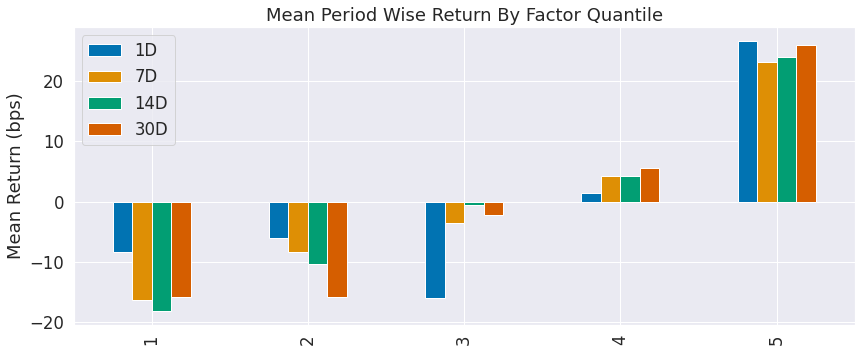

In [12]:
create_summary_tear_sheet(lr_factor_data);

In [13]:
# From Ridge
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [14]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

Dates                      Coin                 
2020-01-11 00:00:00+00:00  basic-attention-token    0.001397
                           binancecoin              0.000491
                           bitcoin                  0.004054
                           bitcoin-cash             0.009623
                           bitcoin-cash-sv          0.020634
dtype: float64

In [15]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 7, 14, 30))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28391 entries, (Timestamp('2020-01-11 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28391 non-null  float64
 1   7D               28391 non-null  float64
 2   14D              28391 non-null  float64
 3   30D              28391 non-null  float64
 4   factor           28391 non-null  float64
 5   factor_quantile  28391 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.125133,0.039752,-0.012544,0.013369,5824,20.513543
2,-0.067022,0.049741,-0.005000,0.009519,5823,20.510021
3,-0.060218,0.056547,-0.001767,0.009048,5097,17.952872
4,-0.049497,0.062096,0.001324,0.008954,5823,20.510021
5,-0.044761,0.115368,0.007399,0.010800,5824,20.513543


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,0.659,0.457,0.385,0.401
beta,0.030,0.103,0.159,0.147
Mean Period Wise Return Top Quantile (bps),22.309,21.920,24.982,26.648
Mean Period Wise Return Bottom Quantile (bps),-9.176,-15.292,-15.145,-17.259
Mean Period Wise Spread (bps),31.485,36.404,39.564,43.280


Information Analysis


,1D,7D,14D,30D
IC Mean,0.028,0.051,0.076,0.106
IC Std.,0.212,0.216,0.221,0.233
Risk-Adjusted IC,0.134,0.236,0.344,0.455
t-stat(IC),3.613,6.373,9.280,12.287
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.056,-0.223,-0.068,-0.022
IC Kurtosis,-0.243,-0.062,-0.206,-0.426


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.386,0.622,0.684,0.756
Quantile 2 Mean Turnover,0.589,0.735,0.766,0.781
Quantile 3 Mean Turnover,0.656,0.775,0.789,0.796
Quantile 4 Mean Turnover,0.585,0.740,0.759,0.776
Quantile 5 Mean Turnover,0.387,0.630,0.691,0.747


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.671,0.295,0.181,0.06


<Figure size 432x288 with 0 Axes>

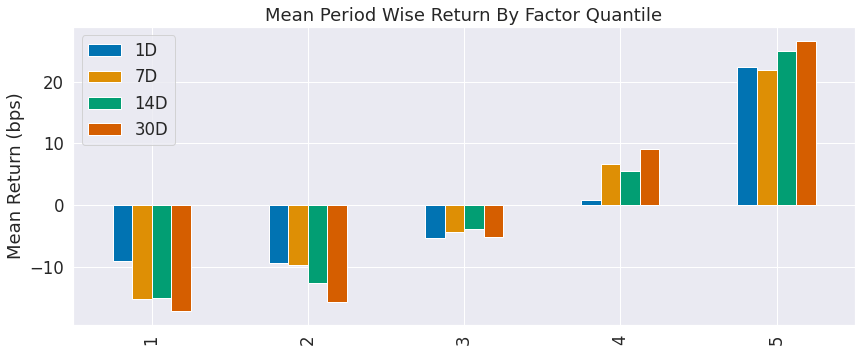

In [16]:
create_summary_tear_sheet(ridge_factor_data);

In [17]:
# From Lasso
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [18]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

Dates                      Coin                 
2020-01-11 00:00:00+00:00  basic-attention-token    0.000959
                           binancecoin              0.000754
                           bitcoin                  0.005061
                           bitcoin-cash             0.007528
                           bitcoin-cash-sv          0.016533
dtype: float64

In [19]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 7, 14, 30))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28391 entries, (Timestamp('2020-01-11 00:00:00+0000', tz='UTC', freq='C'), 'basic-attention-token') to (Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'), 'zcash')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               28391 non-null  float64
 1   7D               28391 non-null  float64
 2   14D              28391 non-null  float64
 3   30D              28391 non-null  float64
 4   factor           28391 non-null  float64
 5   factor_quantile  28391 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.4+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.291561,0.061829,-0.016411,0.020445,5824,20.513543
2,-0.197234,0.079440,-0.006713,0.015384,5823,20.510021
3,-0.173367,0.086267,-0.002555,0.014608,5097,17.952872
4,-0.162917,0.096585,0.001507,0.014476,5823,20.510021
5,-0.138301,0.156787,0.009902,0.017638,5824,20.513543


Returns Analysis


,1D,7D,14D,30D
Ann. alpha,0.793,0.467,0.373,0.423
beta,0.030,0.094,0.155,0.122
Mean Period Wise Return Top Quantile (bps),24.391,25.739,27.376,28.089
Mean Period Wise Return Bottom Quantile (bps),-11.898,-15.181,-15.170,-17.528
Mean Period Wise Spread (bps),36.289,39.891,41.736,44.151


Information Analysis


,1D,7D,14D,30D
IC Mean,0.026,0.043,0.066,0.099
IC Std.,0.215,0.220,0.229,0.231
Risk-Adjusted IC,0.120,0.195,0.288,0.429
t-stat(IC),3.236,5.251,7.770,11.585
p-value(IC),0.001,0.000,0.000,0.000
IC Skew,-0.005,-0.155,-0.127,0.130
IC Kurtosis,-0.202,-0.057,0.111,-0.343


Turnover Analysis


,1D,7D,14D,30D
Quantile 1 Mean Turnover,0.400,0.660,0.709,0.757
Quantile 2 Mean Turnover,0.592,0.746,0.775,0.783
Quantile 3 Mean Turnover,0.666,0.781,0.798,0.807
Quantile 4 Mean Turnover,0.589,0.744,0.767,0.771
Quantile 5 Mean Turnover,0.396,0.664,0.718,0.750


,1D,7D,14D,30D
Mean Factor Rank Autocorrelation,0.65,0.229,0.134,0.045


<Figure size 432x288 with 0 Axes>

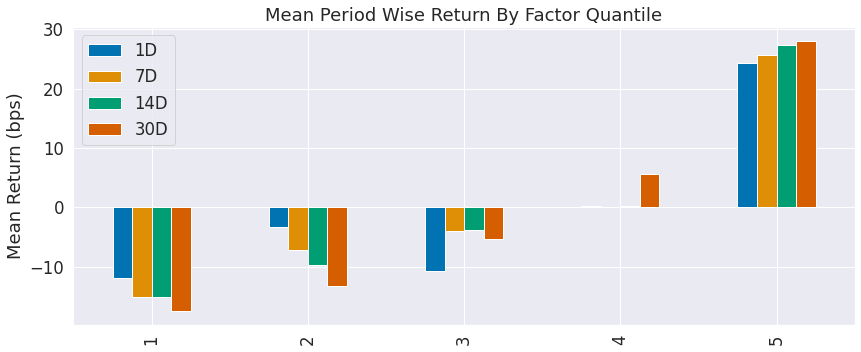

In [20]:
create_summary_tear_sheet(lasso_factor_data);